In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install catboost
!pip3 install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.5 MB/s eta 0:00:00


In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
import unicodedata
from pathlib import Path

import catboost as cb
import optuna
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler
import datetime

In [ ]:

exp_name = 'exp00021'

outputs_path = f'/content/drive/MyDrive/Colab Notebooks/signate2023/{exp_name}/'

submission_dir = outputs_path + 'submissions/'
submission_path = submission_dir + f'submission_{exp_name}.csv'

model_dir = outputs_path + f'signate-models/'

for dir in [model_dir]:
    os.makedirs(dir, exist_ok=True)

In [ ]:
INPUT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/signate2023/")

In [ ]:
train_df = pd.read_csv(INPUT_DIR / "train.csv")
test_df = pd.read_csv(INPUT_DIR / "test.csv")
sub_df = pd.read_csv(INPUT_DIR / "submit_sample.csv", names=["id", "price"])

In [ ]:
import unicodedata

# Define a function to normalize manufacturer names
def normalize_manufacturer_name(name):
    # Convert full-width characters to half-width
    name = unicodedata.normalize('NFKC', name)
    # Convert to lowercase
    name = name.lower()
    # Remove non-ASCII characters
    name = ''.join(char for char in name if ord(char) < 128)
    return name


class PreProcessTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # cylinderから数値を取り出す
        X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").astype("float32")

        # sizeの表記揺れを修正
        X["size"] = X["size"].str.replace("ー", "-").astype(str)
        X["size"] = X["size"].str.replace("−", "-").astype(str)

        # Apply the function to the 'manufacturer' column
        X['manufacturer'] = X['manufacturer'].apply(normalize_manufacturer_name)

        X.loc[X['odometer'] == -1, 'odometer'] = np.nan


        # Define a dictionary for manufacturer name mapping with special characters
        manufacturer_name_mapping = {
            'nisan': 'nissan',
            'toyot': 'toyota',
            'nisѕan': 'nissan',
            'subαru': 'subaru',
            'subru': 'subaru',
            'sαturn': 'saturn',
            'lexu':'lexus',
            'аcura': 'acura',
            'vоlkswagen': 'volkswagen',
            'vlkswagen': 'volkswagen',
            'lexuѕ': 'lexus',
            'ᴄhrysler': 'chrysler',
            'sturn': 'saturn'
        }

        # Replace the manufacturer names using the mapping
        X['manufacturer'] = X['manufacturer'].replace(manufacturer_name_mapping)


        # yearが3000年以降のものはおかしいので2000年に置換
        err_idx = X.query("year >= 3000").index
        X.loc[err_idx, "year"] = X.loc[err_idx, "year"].apply(lambda x: x - 1000)

        # 走行距離 / 製造年
        X["odometer_per_year"] = X["odometer"] / (2023 - X["year"])

        return X


class RankTransformer(TransformerMixin, BaseEstimator):
    """keyの中でvalueが何番目のものか"""

    def __init__(self, key: str, value: str):
        self.key = key
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()
        X_new[self.key] = X_new.groupby(self.key)[self.value].rank(method="dense")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return [self.key]


class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        #X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")

        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols


class CountTransformer(TransformerMixin, BaseEstimator):
    """CountEncoder"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.ce = CountEncoder(cols=X.columns.tolist(), handle_unknown=0)
        self.ce.fit(X)
        return self

    def transform(self, X):
        return self.ce.transform(X)

    def get_feature_names_out(self, input_features=None):
        return input_features


class AggTransformer(TransformerMixin, BaseEstimator):
    """集約特徴量"""

    def __init__(self, key, numeric_cols, agg_func: dict):
        self.key = key
        self.numeric_cols = numeric_cols
        self.agg_func = agg_func

    def fit(self, X, y=None):
        X = X.copy()
        X[self.key] = X[self.key].astype("category")
        self.agg_df = X.groupby(self.key)[self.numeric_cols].agg(self.agg_func)
        self.agg_df.columns = [f"{col}_{func}" for col, func in self.agg_df.columns.tolist()]

        return self

    def transform(self, X):
        X_new = pd.merge(X, self.agg_df, on=self.key, how="left")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return self.agg_df.columns.tolist()

In [ ]:
numeric_cols = ["year", "odometer", "odometer_per_year"]
categorical_cols = [
    'region',
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
]

ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            categorical_cols + numeric_cols,
        ),
        (
            "ct",
            CountTransformer(),
            categorical_cols
        ),
        *[
             (f"agg_{key}", AggTransformer(key, ["odometer"], {"mean", "std"}), [key] + ["odometer"])
             for key in [
                 "manufacturer",
                 "cylinders",
                 "condition",
                 "fuel",
                 "drive",
                 "size",
                 "type",
             ]
         ],
    ],
    verbose=True,
)
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ("ct", ct),
    ]
)

train_feat_df = pipe.fit_transform(train_df, train_df["price"])
test_feat_df = pipe.transform(test_df)

[ColumnTransformer] ........... (1 of 9) Processing ori, total=   0.0s
[ColumnTransformer] ............ (2 of 9) Processing ct, total=   0.6s
[ColumnTransformer]  (3 of 9) Processing agg_manufacturer, total=   0.0s
[ColumnTransformer] . (4 of 9) Processing agg_cylinders, total=   0.0s
[ColumnTransformer] . (5 of 9) Processing agg_condition, total=   0.0s
[ColumnTransformer] ...... (6 of 9) Processing agg_fuel, total=   0.0s
[ColumnTransformer] ..... (7 of 9) Processing agg_drive, total=   0.0s
[ColumnTransformer] ...... (8 of 9) Processing agg_size, total=   0.0s
[ColumnTransformer] ...... (9 of 9) Processing agg_type, total=   0.0s


In [ ]:
train_feat_df

,ori__year,ori__odometer,ori__odometer_per_year,ori__region,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,...,agg_condition__odometer_std,agg_condition__odometer_mean,agg_fuel__odometer_std,agg_fuel__odometer_mean,agg_drive__odometer_std,agg_drive__odometer_mean,agg_size__odometer_std,agg_size__odometer_mean,agg_type__odometer_std,agg_type__odometer_mean
0,1949.0,115148.0,1556.054077,nashville,6.0,bmw,excellent,gas,clean,manual,...,62813.625983,111814.618855,60301.369067,117726.484604,62270.608521,98224.433682,65581.670291,115464.542489,54324.383605,102805.990385
1,2013.0,172038.0,17203.800781,state college,8.0,toyota,fair,gas,clean,automatic,...,61282.605340,154892.925693,60301.369067,117726.484604,62270.608521,98224.433682,63969.010186,118350.530207,57689.686211,115614.553873
2,1998.0,152492.0,6099.680176,wichita,6.0,ford,good,gas,clean,automatic,...,62670.409248,128844.689852,60301.369067,117726.484604,59606.212399,121154.333817,63969.010186,118350.530207,70098.520676,123372.880094
3,2014.0,104118.0,11568.666992,albany,4.0,ford,excellent,gas,clean,manual,...,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,70098.520676,123372.880094
4,2005.0,144554.0,8030.777832,redding,6.0,ford,excellent,gas,clean,manual,...,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,57689.686211,115614.553873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,2008.0,26660.0,1777.333374,williamsport,6.0,ford,good,gas,clean,automatic,...,62670.409248,128844.689852,60301.369067,117726.484604,62270.608521,98224.433682,57751.535407,116521.806811,64907.929089,116433.973414
27528,2007.0,108072.0,6754.500000,tulsa,8.0,ford,excellent,gas,clean,automatic,...,62813.625983,111814.618855,60301.369067,117726.484604,62270.608521,98224.433682,63969.010186,118350.530207,66642.555478,116285.176134
27529,2019.0,139908.0,34977.000000,rochester,6.0,jeep,like new,gas,clean,automatic,...,57656.409651,96607.548515,60301.369067,117726.484604,69736.633841,121182.685864,65581.670291,115464.542489,70098.520676,123372.880094
27530,2007.0,112326.0,7020.375000,rochester,6.0,jeep,excellent,gas,clean,automatic,...,62813.625983,111814.618855,60301.369067,117726.484604,69736.633841,121182.685864,65581.670291,115464.542489,57689.686211,115614.553873


In [ ]:
state_dic = {}

# データ数的に、重複は気にせず上書きしていっても大した時間にはならない
for i in train_feat_df.index:
    # ただし、欠損値で上書きされると困るので、そこだけケア
    if pd.isna(train_feat_df.at[i, 'ori__state'])==False:
        state_dic[train_feat_df.at[i, 'ori__region']] = train_feat_df.at[i, 'ori__state']

train_feat_df.loc[pd.isna(train_feat_df['ori__state']).index, 'ori__state'] = train_feat_df.loc[pd.isna(train_feat_df['ori__state']).index, 'ori__region'].map(state_dic)
test_feat_df.loc[pd.isna(test_feat_df['ori__state']).index, 'ori__state'] = test_feat_df.loc[pd.isna(test_feat_df['ori__state']).index, 'ori__region'].map(state_dic)

In [ ]:
pd.set_option('display.max_columns', None)
train_feat_df

,ori__year,ori__odometer,ori__odometer_per_year,ori__region,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,ori__drive,ori__size,ori__type,ori__paint_color,ori__state,ct__region,ct__cylinders,ct__manufacturer,ct__condition,ct__fuel,ct__title_status,ct__transmission,ct__drive,ct__size,ct__type,ct__paint_color,ct__state,agg_manufacturer__odometer_std,agg_manufacturer__odometer_mean,agg_cylinders__odometer_std,agg_cylinders__odometer_mean,agg_condition__odometer_std,agg_condition__odometer_mean,agg_fuel__odometer_std,agg_fuel__odometer_mean,agg_drive__odometer_std,agg_drive__odometer_mean,agg_size__odometer_std,agg_size__odometer_mean,agg_type__odometer_std,agg_type__odometer_mean
0,1949.0,115148.0,1556.054077,nashville,6.0,bmw,excellent,gas,clean,manual,rwd,mid-size,convertible,orange,tn,229,11504,3044,15219,23546,22365,6156,4834,9411,418,144,3304,54592.395342,99532.887011,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,62270.608521,98224.433682,65581.670291,115464.542489,54324.383605,102805.990385
1,2013.0,172038.0,17203.800781,state college,8.0,toyota,fair,gas,clean,automatic,rwd,full-size,sedan,silver,pa,12,5727,1784,2404,23546,22365,20497,4834,14636,9259,4300,983,63883.018881,150274.987542,62494.750709,115307.855683,61282.605340,154892.925693,60301.369067,117726.484604,62270.608521,98224.433682,63969.010186,118350.530207,57689.686211,115614.553873
2,1998.0,152492.0,6099.680176,wichita,6.0,ford,good,gas,clean,automatic,fwd,full-size,SUV,silver,ks,233,11504,6943,6009,23546,22365,20497,14602,14636,7311,4300,252,63040.922707,117902.164170,62481.637708,117712.542875,62670.409248,128844.689852,60301.369067,117726.484604,59606.212399,121154.333817,63969.010186,118350.530207,70098.520676,123372.880094
3,2014.0,104118.0,11568.666992,albany,4.0,ford,excellent,gas,clean,manual,fwd,mid-size,SUV,blue,ny,504,10071,6943,15219,23546,22365,6156,14602,9411,7311,3765,1841,63040.922707,117902.164170,65948.060685,117652.023240,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,70098.520676,123372.880094
4,2005.0,144554.0,8030.777832,redding,6.0,ford,excellent,gas,clean,manual,fwd,mid-size,sedan,red,ca,153,11504,6943,15219,23546,22365,6156,14602,9411,9259,1419,2702,63040.922707,117902.164170,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,57689.686211,115614.553873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,2008.0,26660.0,1777.333374,williamsport,6.0,ford,good,gas,clean,automatic,rwd,compact,truck,black,pa,49,11504,6943,6009,23546,22365,20497,4834,3352,3837,10143,983,63040.922707,117902.164170,62481.637708,117712.542875,62670.409248,128844.689852,60301.369067,117726.484604,62270.608521,98224.433682,57751.535407,116521.806811,64907.929089,116433.973414
27528,2007.0,108072.0,6754.500000,tulsa,8.0,ford,excellent,gas,clean,automatic,rwd,full-size,pickup,black,ok,166,5727,6943,15219,23546,22365,20497,4834,14636,2118,10143,3304,63040.922707,117902.164170,62494.750709,115307.855683,62813.625983,111814.618855,60301.369067,117726.484604,62270.608521,98224.433682,63969.010186,118350.530207,66642.555478,116285.176134
27529,2019.0,139908.0,34977.000000,rochester,6.0,jeep,like new,gas,clean,automatic,4wd,mid-size,SUV,white,ny,522,11504,1297,3810,23546,22365,20497,8096,9411,7311,3624,1841,55275.381309,124203.237129,62481.637708,117712.542875,57656.409651,96607.548515,60301.369067,117726.484604,69736.633841,121182.685864,65581.670291,115464.542489,70098.520676,123372.880094
27530,2007.0,112326.0,7020.375000,rochester,6.0,jeep,excellent,gas,clean,automatic,4wd,mid-size,sedan,white,ny,522,11504,1297,15219,23546,22365,20497,8096,9411,9259,3624,1841,55275.381309,124203.237129,62481.637708,117712.542875,62813.625983,11

In [ ]:
# Create a discretizer
#discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
#train_data_encoded['odometer_binned'] = discretizer.fit_transform(train_data_encoded[['ori__odometer']])
#test_data_encoded['odometer_binned'] = discretizer.transform(test_data_encoded[['ori__odometer']])

In [ ]:
# Create a robust scaler
scaler = RobustScaler()
train_feat_df['odometer_scaled'] = scaler.fit_transform(train_feat_df[['ori__odometer']])
test_feat_df['odometer_scaled'] = scaler.transform(test_feat_df[['ori__odometer']])

In [ ]:
# Apply log transformation to 'odometer'
train_feat_df['odometer_log'] = np.log1p(train_feat_df['ori__odometer'])
test_feat_df['odometer_log'] = np.log1p(test_feat_df['ori__odometer'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Create a new feature 'car_age'
current_year = datetime.datetime.now().year
train_feat_df['car_age'] = current_year - train_feat_df['ori__year']
test_feat_df['car_age'] = current_year - test_feat_df['ori__year']

In [ ]:
# odometer_scaledとcar_ageの交互作用を新たな特徴量として作成します
train_feat_df['odometer_age_interaction'] = train_feat_df['ori__odometer'] * train_feat_df['car_age']
test_feat_df['odometer_age_interaction'] = test_feat_df['ori__odometer'] * test_feat_df['car_age']

In [ ]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# SimpleImputerをインスタンス化（ここでは欠損値を中央値で補完）
imputer = SimpleImputer(strategy='median')

# 補完を行いたい特徴量を選択
features = train_feat_df[['ori__odometer', 'car_age']].copy()

# 欠損値補完
features_imputed = imputer.fit_transform(features)

# KMeansクラスタリングを設定
kmeans = KMeans(n_clusters=10, random_state=0)

# 補完されたデータに基づいてクラスタリング
train_feat_df['odometer_age_cluster'] = kmeans.fit_predict(features_imputed)

# テストデータについても同様に処理
features_test = test_feat_df[['ori__odometer', 'car_age']].copy()
features_test_imputed = imputer.transform(features_test)
test_feat_df['odometer_age_cluster'] = kmeans.predict(features_test_imputed)

# 元のodometer_scaledの欠損値を復元
train_feat_df['ori__odometer'] = features['ori__odometer']
test_feat_df['ori__odometer'] = features_test['ori__odometer']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
train_feat_df

,ori__year,ori__odometer,ori__odometer_per_year,ori__region,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,ori__drive,ori__size,ori__type,ori__paint_color,ori__state,ct__region,ct__cylinders,ct__manufacturer,ct__condition,ct__fuel,ct__title_status,ct__transmission,ct__drive,ct__size,ct__type,ct__paint_color,ct__state,agg_manufacturer__odometer_std,agg_manufacturer__odometer_mean,agg_cylinders__odometer_std,agg_cylinders__odometer_mean,agg_condition__odometer_std,agg_condition__odometer_mean,agg_fuel__odometer_std,agg_fuel__odometer_mean,agg_drive__odometer_std,agg_drive__odometer_mean,agg_size__odometer_std,agg_size__odometer_mean,agg_type__odometer_std,agg_type__odometer_mean,odometer_scaled,odometer_log,car_age,odometer_age_interaction,odometer_age_cluster
0,1949.0,115148.0,1556.054077,nashville,6.0,bmw,excellent,gas,clean,manual,rwd,mid-size,convertible,orange,tn,229,11504,3044,15219,23546,22365,6156,4834,9411,418,144,3304,54592.395342,99532.887011,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,62270.608521,98224.433682,65581.670291,115464.542489,54324.383605,102805.990385,0.043134,11.653982,74.0,8520952.0,0
1,2013.0,172038.0,17203.800781,state college,8.0,toyota,fair,gas,clean,automatic,rwd,full-size,sedan,silver,pa,12,5727,1784,2404,23546,22365,20497,4834,14636,9259,4300,983,63883.018881,150274.987542,62494.750709,115307.855683,61282.605340,154892.925693,60301.369067,117726.484604,62270.608521,98224.433682,63969.010186,118350.530207,57689.686211,115614.553873,0.834587,12.055476,10.0,1720380.0,5
2,1998.0,152492.0,6099.680176,wichita,6.0,ford,good,gas,clean,automatic,fwd,full-size,SUV,silver,ks,233,11504,6943,6009,23546,22365,20497,14602,14636,7311,4300,252,63040.922707,117902.164170,62481.637708,117712.542875,62670.409248,128844.689852,60301.369067,117726.484604,59606.212399,121154.333817,63969.010186,118350.530207,70098.520676,123372.880094,0.562663,11.934874,25.0,3812300.0,3
3,2014.0,104118.0,11568.666992,albany,4.0,ford,excellent,gas,clean,manual,fwd,mid-size,SUV,blue,ny,504,10071,6943,15219,23546,22365,6156,14602,9411,7311,3765,1841,63040.922707,117902.164170,65948.060685,117652.023240,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,70098.520676,123372.880094,-0.110315,11.553289,9.0,937062.0,8
4,2005.0,144554.0,8030.777832,redding,6.0,ford,excellent,gas,clean,manual,fwd,mid-size,sedan,red,ca,153,11504,6943,15219,23546,22365,6156,14602,9411,9259,1419,2702,63040.922707,117902.164170,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,57689.686211,115614.553873,0.452230,11.881415,18.0,2601972.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,2008.0,26660.0,1777.333374,williamsport,6.0,ford,good,gas,clean,automatic,rwd,compact,truck,black,pa,49,11504,6943,6009,23546,22365,20497,4834,3352,3837,10143,983,63040.922707,117902.164170,62481.637708,117712.542875,62670.409248,128844.689852,60301.369067,117726.484604,62270.608521,98224.433682,57751.535407,116521.806811,64907.929089,116433.973414,-1.187909,10.190957,15.0,399900.0,7
27528,2007.0,108072.0,6754.500000,tulsa,8.0,ford,excellent,gas,clean,automatic,rwd,full-size,pickup,black,ok,166,5727,6943,15219,23546,22365,20497,4834,14636,2118,10143,3304,63040.922707,117902.164170,62494.750709,115307.855683,62813.625983,111814.618855,60301.369067,117726.484604,62270.608521,98224.433682,63969.010186,118350.530207,66642.555478,116285.176134,-0.055307,11.590562,16.0,1729152.0,0
27529,2019.0,139908.0,34977.000000,rochester,6.0,jeep,like new,gas,clean,automatic,4wd,mid-size,SUV,white,ny,522,11504,1297,3810,23546,22365,20497,8096,9411,7311,3624,1841,55275.381309,124203.237129,62481.637708,117712.542875,57656.409651,96607.5485

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# 3. Binning features
# Binning 'odometer_scaled' into 10 bins
train_feat_df['odometer_scaled_bin'] = pd.cut(train_feat_df['ori__odometer'], bins=10, labels=False)
test_feat_df['odometer_scaled_bin'] = pd.cut(test_feat_df['ori__odometer'], bins=10, labels=False)

# Binning 'car_age' into 10 bins
train_feat_df['car_age_bin'] = pd.cut(train_feat_df['car_age'], bins=10, labels=False)
test_feat_df['car_age_bin'] = pd.cut(test_feat_df['car_age'], bins=10, labels=False)

# One-hot encoding the binned features
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# 'odometer_scaled_bin'
ohe.fit(train_feat_df[['odometer_scaled_bin']])
train_data_ohe = pd.DataFrame(ohe.transform(train_feat_df[['odometer_scaled_bin']]), columns=[f"odometer_scaled_bin_{c}" for c in ohe.categories_[0]])
test_data_ohe = pd.DataFrame(ohe.transform(test_feat_df[['odometer_scaled_bin']]), columns=[f"odometer_scaled_bin_{c}" for c in ohe.categories_[0]])
train_feat_df = pd.concat([train_feat_df, train_data_ohe], axis=1)
test_feat_df = pd.concat([test_feat_df, test_data_ohe], axis=1)
train_feat_df.drop('odometer_scaled_bin', axis=1, inplace=True)
test_feat_df.drop('odometer_scaled_bin', axis=1, inplace=True)

# 'car_age_bin'
ohe.fit(train_feat_df[['car_age_bin']])
train_data_ohe = pd.DataFrame(ohe.transform(train_feat_df[['car_age_bin']]), columns=[f"car_age_bin_{c}" for c in ohe.categories_[0]])
test_data_ohe = pd.DataFrame(ohe.transform(test_feat_df[['car_age_bin']]), columns=[f"car_age_bin_{c}" for c in ohe.categories_[0]])
train_feat_df = pd.concat([train_feat_df, train_data_ohe], axis=1)
test_feat_df = pd.concat([test_feat_df, test_data_ohe], axis=1)
train_feat_df.drop('car_age_bin', axis=1, inplace=True)
test_feat_df.drop('car_age_bin', axis=1, inplace=True)
train_feat_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,ori__year,ori__odometer,ori__odometer_per_year,ori__region,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,ori__drive,ori__size,ori__type,ori__paint_color,ori__state,ct__region,ct__cylinders,ct__manufacturer,ct__condition,ct__fuel,ct__title_status,ct__transmission,ct__drive,ct__size,ct__type,ct__paint_color,ct__state,agg_manufacturer__odometer_std,agg_manufacturer__odometer_mean,agg_cylinders__odometer_std,agg_cylinders__odometer_mean,agg_condition__odometer_std,agg_condition__odometer_mean,agg_fuel__odometer_std,agg_fuel__odometer_mean,agg_drive__odometer_std,agg_drive__odometer_mean,agg_size__odometer_std,agg_size__odometer_mean,agg_type__odometer_std,agg_type__odometer_mean,odometer_scaled,odometer_log,car_age,odometer_age_interaction,odometer_age_cluster,odometer_scaled_bin_0.0,odometer_scaled_bin_1.0,odometer_scaled_bin_4.0,odometer_scaled_bin_5.0,odometer_scaled_bin_9.0,odometer_scaled_bin_nan,car_age_bin_0,car_age_bin_9
0,1949.0,115148.0,1556.054077,nashville,6.0,bmw,excellent,gas,clean,manual,rwd,mid-size,convertible,orange,tn,229,11504,3044,15219,23546,22365,6156,4834,9411,418,144,3304,54592.395342,99532.887011,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,62270.608521,98224.433682,65581.670291,115464.542489,54324.383605,102805.990385,0.043134,11.653982,74.0,8520952.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2013.0,172038.0,17203.800781,state college,8.0,toyota,fair,gas,clean,automatic,rwd,full-size,sedan,silver,pa,12,5727,1784,2404,23546,22365,20497,4834,14636,9259,4300,983,63883.018881,150274.987542,62494.750709,115307.855683,61282.605340,154892.925693,60301.369067,117726.484604,62270.608521,98224.433682,63969.010186,118350.530207,57689.686211,115614.553873,0.834587,12.055476,10.0,1720380.0,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1998.0,152492.0,6099.680176,wichita,6.0,ford,good,gas,clean,automatic,fwd,full-size,SUV,silver,ks,233,11504,6943,6009,23546,22365,20497,14602,14636,7311,4300,252,63040.922707,117902.164170,62481.637708,117712.542875,62670.409248,128844.689852,60301.369067,117726.484604,59606.212399,121154.333817,63969.010186,118350.530207,70098.520676,123372.880094,0.562663,11.934874,25.0,3812300.0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2014.0,104118.0,11568.666992,albany,4.0,ford,excellent,gas,clean,manual,fwd,mid-size,SUV,blue,ny,504,10071,6943,15219,23546,22365,6156,14602,9411,7311,3765,1841,63040.922707,117902.164170,65948.060685,117652.023240,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,70098.520676,123372.880094,-0.110315,11.553289,9.0,937062.0,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2005.0,144554.0,8030.777832,redding,6.0,ford,excellent,gas,clean,manual,fwd,mid-size,sedan,red,ca,153,11504,6943,15219,23546,22365,6156,14602,9411,9259,1419,2702,63040.922707,117902.164170,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,59606.212399,121154.333817,65581.670291,115464.542489,57689.686211,115614.553873,0.452230,11.881415,18.0,2601972.0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# 1. odometerに対する他の特徴量の比率
# 年ごとの平均odometer値を計算
mean_odometer_per_year = train_feat_df.groupby('ori__year')['ori__odometer'].transform('mean')
# 年ごとのodometerの比率を計算
train_feat_df['odometer_ratio_year'] = train_feat_df['ori__odometer'] / mean_odometer_per_year
# 同様にテストデータセットに対しても行う
mean_odometer_per_year_test = test_feat_df.groupby('ori__year')['ori__odometer'].transform('mean')
test_feat_df['odometer_ratio_year'] = test_feat_df['ori__odometer'] / mean_odometer_per_year_test

# 2. 'odometer'の時間経過による変化
train_feat_df['odometer_per_year'] = train_feat_df['ori__odometer'] / train_feat_df['car_age']
test_feat_df['odometer_per_year'] = test_feat_df['ori__odometer'] / test_feat_df['car_age']

# 4. 'odometer'のランク
train_feat_df['odometer_rank_region'] = train_feat_df.groupby('ori__region')['ori__odometer'].rank()
test_feat_df['odometer_rank_region'] = test_feat_df.groupby('ori__region')['ori__odometer'].rank()

# 5. 'odometer'のビン化
train_feat_df['odometer_bin_100k'] = pd.cut(train_feat_df['ori__odometer'], bins=[0, 100000, 200000, 300000, np.inf], labels=False)
test_feat_df['odometer_bin_100k'] = pd.cut(test_feat_df['ori__odometer'], bins=[0, 100000, 200000, 300000, np.inf], labels=False)

# 6. 'odometer'の他の数学的変換
train_feat_df['odometer_sqrt'] = np.sqrt(train_feat_df['ori__odometer'])
test_feat_df['odometer_sqrt'] = np.sqrt(test_feat_df['ori__odometer'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
train_feat_df['year_odometer_ratio'] = train_feat_df['ori__odometer'] / (2023 - train_feat_df['ori__year'])
test_feat_df['year_odometer_ratio'] = test_feat_df['ori__odometer'] / (2023 - test_feat_df['ori__year'])

In [ ]:


# List of categorical columns to apply label encoding
label_cols = ['ori__region']
onehot_cols = ['ori__manufacturer', 'ori__condition', 'ori__fuel', 'ori__title_status',
               'ori__transmission', 'ori__drive', 'ori__size', 'ori__type', 'ori__paint_color', 'ori__state']

# Create a copy of the dataframes
train_data_encoded = train_feat_df.copy()
test_data_encoded = test_feat_df.copy()

# Instantiate the LabelEncoder and OneHotEncoder
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False)

# Apply label encoding
for col in label_cols:
    # Fit the encoder on the training data
    le.fit(train_data_encoded[col])

    # Transform the data
    train_data_encoded['label_' + col] = le.transform(train_data_encoded[col])
    test_data_encoded['label_' + col] = le.transform(test_data_encoded[col])

# Apply one-hot encoding
for col in onehot_cols:
    # Fit the encoder on the training data
    ohe.fit(train_data_encoded[[col]])

    # Transform the data
    train_data_ohe = pd.DataFrame(ohe.transform(train_data_encoded[[col]]), columns=[f"{col}_{c}" for c in ohe.categories_[0]])
    test_data_ohe = pd.DataFrame(ohe.transform(test_data_encoded[[col]]), columns=[f"{col}_{c}" for c in ohe.categories_[0]])

    # Drop the original column
    #train_data_encoded.drop(col, axis=1, inplace=True)
    #test_data_encoded.drop(col, axis=1, inplace=True)

    # Concatenate the one-hot encoded columns
    train_data_encoded = pd.concat([train_data_encoded, train_data_ohe], axis=1)
    test_data_encoded = pd.concat([test_data_encoded, test_data_ohe], axis=1)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

In [ ]:
train_feat_df = train_data_encoded
test_feat_df = test_data_encoded

In [ ]:
def get_cv(df, n_fold=5):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

n_fold = 5
feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()
cv = get_cv(train_feat_df, n_fold=5)

In [ ]:
train_feat_df

,ori__year,ori__odometer,ori__odometer_per_year,ori__region,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,ori__drive,ori__size,ori__type,ori__paint_color,ori__state,ct__region,ct__cylinders,ct__manufacturer,ct__condition,ct__fuel,ct__title_status,ct__transmission,ct__drive,ct__size,ct__type,ct__paint_color,ct__state,agg_manufacturer__odometer_std,agg_manufacturer__odometer_mean,agg_cylinders__odometer_std,agg_cylinders__odometer_mean,agg_condition__odometer_std,agg_condition__odometer_mean,agg_fuel__odometer_std,agg_fuel__odometer_mean,agg_drive__odometer_std,agg_drive__odometer_mean,agg_size__odometer_std,agg_size__odometer_mean,agg_type__odometer_std,agg_type__odometer_mean,odometer_scaled,odometer_log,car_age,odometer_age_interaction,odometer_age_cluster,odometer_scaled_bin_0.0,odometer_scaled_bin_1.0,odometer_scaled_bin_4.0,odometer_scaled_bin_5.0,odometer_scaled_bin_9.0,odometer_scaled_bin_nan,car_age_bin_0,car_age_bin_9,odometer_ratio_year,odometer_per_year,odometer_rank_region,odometer_bin_100k,odometer_sqrt,year_odometer_ratio,label_ori__region,ori__manufacturer_acura,ori__manufacturer_alfa-romeo,ori__manufacturer_aston-martin,ori__manufacturer_audi,ori__manufacturer_bmw,ori__manufacturer_buick,ori__manufacturer_cadillac,ori__manufacturer_chevrolet,ori__manufacturer_chrysler,ori__manufacturer_cura,ori__manufacturer_dodge,ori__manufacturer_fiat,ori__manufacturer_ford,ori__manufacturer_gmc,ori__manufacturer_honda,ori__manufacturer_hrysler,ori__manufacturer_hyundai,ori__manufacturer_infiniti,ori__manufacturer_jaguar,ori__manufacturer_jeep,ori__manufacturer_kia,ori__manufacturer_land rover,ori__manufacturer_lexus,ori__manufacturer_lincoln,ori__manufacturer_mazda,ori__manufacturer_mercedes-benz,ori__manufacturer_mercury,ori__manufacturer_mini,ori__manufacturer_mitsubishi,ori__manufacturer_nissan,ori__manufacturer_pontiac,ori__manufacturer_porsche,ori__manufacturer_ram,ori__manufacturer_rover,ori__manufacturer_saturn,ori__manufacturer_subaru,ori__manufacturer_toyota,ori__manufacturer_volkswagen,ori__manufacturer_volvo,ori__condition_excellent,ori__condition_fair,ori__condition_good,ori__condition_like new,ori__condition_new,ori__condition_salvage,ori__fuel_diesel,ori__fuel_electric,ori__fuel_gas,ori__fuel_hybrid,ori__fuel_other,ori__fuel_nan,ori__title_status_clean,ori__title_status_lien,ori__title_status_missing,ori__title_status_parts only,ori__title_status_rebuilt,ori__title_status_salvage,ori__title_status_nan,ori__transmission_automatic,ori__transmission_manual,ori__transmission_other,ori__drive_4wd,ori__drive_fwd,ori__drive_rwd,ori__size_compact,ori__size_full-size,ori__size_mid-size,ori__size_sub-compact,ori__type_SUV,ori__type_bus,ori__type_convertible,ori__type_coupe,ori__type_hatchback,ori__type_mini-van,ori__type_offroad,ori__type_other,ori__type_pickup,ori__type_sedan,ori__type_truck,ori__type_van,ori__type_wagon,ori__type_nan,ori__paint_color_black,ori__paint_color_blue,ori__paint_color_brown,ori__paint_color_custom,ori__paint_color_green,ori__paint_color_grey,ori__paint_color_orange,ori__paint_color_purple,ori__paint_color_red,ori__paint_color_silver,ori__paint_color_white,ori__paint_color_yellow,ori__state_ak,ori__state_al,ori__state_ar,ori__state_az,ori__state_ca,ori__state_co,ori__state_ct,ori__state_dc,ori__state_de,ori__state_fl,ori__state_ga,ori__state_hi,ori__state_ia,ori__state_id,ori__state_il,ori__state_in,ori__state_ks,ori__state_ky,ori__state_la,ori__state_ma,ori__state_md,ori__state_me,ori__state_mi,ori__state_mn,ori__state_mo,ori__state_ms,ori__state_mt,ori__state_nc,ori__state_nd,ori__state_ne,ori__state_nh,ori__state_nj,ori__state_nm,ori__state_nv,ori__state_ny,ori__state_oh,ori__state_ok,ori__state_or,ori__state_pa,ori__state_ri,ori__state_sc,ori__state_sd,ori__state_tn,ori__state_tx,ori__state_ut,ori__state_va,ori__state_vt,ori__state_wa,ori__state_wi,ori__state_wv,ori__state_wy,ori__state_nan
0,1949.0,115148.0,1556.054077,nashville,6.0,bmw,excel

In [ ]:
#train_feat_df = train_feat_df.fillna(train_feat_df.median())

In [ ]:
# infを最大値で置き換える
#train_feat_df = train_feat_df.replace([np.inf, -np.inf], np.nan)
#train_feat_df = train_feat_df.fillna(train_feat_df.max())

In [ ]:
def fit_lgbm(X, y, test_data, cv, te_cols, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    if params is None:
        params = {}

    models = []
    target_encoders = []
    transformed_test_data_list = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        X_tr, y_tr = X.iloc[idx_train], y.iloc[idx_train]
        X_val, y_val = X.iloc[idx_valid], y.iloc[idx_valid]

        transformed_test_data = test_data.copy()

        for col in te_cols:
            te = TargetEncoder(target_type="continuous", random_state=88)
            te.fit(X_tr[[col]], y_tr)
            X_tr['te_' + col] = te.transform(X_tr[[col]])
            X_val['te_' + col] = te.transform(X_val[[col]])
            transformed_test_data['te_' + col] = te.transform(transformed_test_data[[col]])

        drop_cols = ['ori__region', 'ori__manufacturer', 'ori__condition', 'ori__fuel', 'ori__title_status',
               'ori__transmission', 'ori__drive', 'ori__size', 'ori__type', 'ori__paint_color', 'ori__state']
        X_tr.drop(drop_cols, axis=1, inplace=True)
        X_val.drop(drop_cols, axis=1, inplace=True)
        transformed_test_data.drop(drop_cols, axis=1, inplace=True)

        transformed_test_data_list.append(transformed_test_data)

        # Save the fitted target encoder
        target_encoders.append(te)

        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_tr,
            y_tr,
            categorical_feature=categorical_cols,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(100, verbose=verbose)],
        )
        pred_i = model.predict(X_val)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_val, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)
    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models, target_encoders, transformed_test_data_list



# optunaを使ったパラメータチューニング
def tuning(train_feat_df, train_df, cv):
     def objective(trial):
         max_depth = trial.suggest_int("max_depth", 1, 10)
         num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
         colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
         subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
         learning_rate = trial.suggest_float('learning_rate',0.03,0.1)
         n_estimators = trial.suggest_int('n_estimators', 100, 50000)

         params = {
             "objective": "mape",
             "n_estimators": n_estimators,
             "learning_rate": learning_rate,
             "max_depth": max_depth,
             "num_leaves": num_leaves,
             "colsample_bytree": colsample_bytree,
             "subsample": subsample,
             "metric": "mape",
             "importance_type": "gain",
             "random_state": 88,
         }

         te_cols = [
            'ori__region',
            "ori__cylinders",
            "ori__manufacturer",
            "ori__condition",
            "ori__fuel",
            "ori__title_status",
            "ori__transmission",
            "ori__drive",
            "ori__size",
            "ori__type",
            "ori__paint_color",
            "ori__state",
            ]

         score, _, _, _, _ = fit_lgbm(
             X=train_feat_df, y=train_df["price"], test_data=test_feat_df, cv=cv, te_cols=te_cols,  categorical_cols=[], params=params, verbose=-1
         )
         return score

     study = optuna.create_study(direction="minimize")
     study.optimize(objective, n_trials=100)
     print("Number of finished trials:", len(study.trials))
     print("Best trial:", study.best_trial.params)
     return study.best_trial.params

In [ ]:
Best trial: {'max_depth': 6, 'num_leaves': 59,'colsample_bytree': 0.10129137174358303,'subsample': 0.3885966772598693,'learning_rate': 0.03355093645103734,'n_estimators': 42242}
FINISHI: Whole Score: 0.4417

SyntaxError: ignored

In [ ]:
lgbm_params = {
    "objective": "mape",
    "metrics": "mape",
    "n_estimators": 42242,
    "learning_rate": 0.03355093645103734,
    "max_depth": 6,
    "num_leaves": 59,
    "colsample_bytree": 0.10129137174358303,
    "subsample":  0.3885966772598693,
    "importance_type": "gain",
    "random_state": 88,
}

te_cols = [
            'ori__region',
            "ori__cylinders",
            "ori__manufacturer",
            "ori__condition",
            "ori__fuel",
            "ori__title_status",
            "ori__transmission",
            "ori__drive",
            "ori__size",
            "ori__type",
            "ori__paint_color",
            "ori__state",
            ]

# training
score, oof_lgb, models_lgb, target_encoders, transformed_test_data_list  = fit_lgbm(
    train_feat_df,
    y=train_df["price"],
    test_data=test_feat_df,
    te_cols=te_cols,
    categorical_cols=[],
    params=lgbm_params,
    cv=cv,
    verbose=False,
)

<ipython-input-28-2b3fb3c8f038>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr['te_' + col] = te.transform(X_tr[[col]])
<ipython-input-28-2b3fb3c8f038>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['te_' + col] = te.transform(X_val[[col]])
<ipython-input-28-2b3fb3c8f038>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

 - fold1 - 0.4462


<ipython-input-28-2b3fb3c8f038>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr['te_' + col] = te.transform(X_tr[[col]])
<ipython-input-28-2b3fb3c8f038>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['te_' + col] = te.transform(X_val[[col]])
<ipython-input-28-2b3fb3c8f038>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

 - fold2 - 0.4385


<ipython-input-28-2b3fb3c8f038>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr['te_' + col] = te.transform(X_tr[[col]])
<ipython-input-28-2b3fb3c8f038>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['te_' + col] = te.transform(X_val[[col]])
<ipython-input-28-2b3fb3c8f038>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

 - fold3 - 0.4413


<ipython-input-28-2b3fb3c8f038>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr['te_' + col] = te.transform(X_tr[[col]])
<ipython-input-28-2b3fb3c8f038>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['te_' + col] = te.transform(X_val[[col]])
<ipython-input-28-2b3fb3c8f038>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

 - fold4 - 0.4444


<ipython-input-28-2b3fb3c8f038>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr['te_' + col] = te.transform(X_tr[[col]])
<ipython-input-28-2b3fb3c8f038>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['te_' + col] = te.transform(X_val[[col]])
<ipython-input-28-2b3fb3c8f038>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

 - fold5 - 0.4380
FINISHI: Whole Score: 0.4417


In [ ]:
train_feat_df

,ori__year,ori__odometer,ori__odometer_per_year,ori__region,ori__cylinders,ct__region,ct__cylinders,ct__manufacturer,ct__condition,ct__fuel,ct__title_status,ct__transmission,ct__drive,ct__size,ct__type,ct__paint_color,ct__state,tgt__region,tgt__cylinders,tgt__manufacturer,tgt__condition,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state,agg_manufacturer__odometer_std,agg_manufacturer__odometer_mean,agg_cylinders__odometer_std,agg_cylinders__odometer_mean,agg_condition__odometer_std,agg_condition__odometer_mean,agg_fuel__odometer_std,agg_fuel__odometer_mean,agg_drive__odometer_std,agg_drive__odometer_mean,agg_size__odometer_std,agg_size__odometer_mean,agg_type__odometer_std,agg_type__odometer_mean,ori__manufacturer_acura,ori__manufacturer_alfa-romeo,ori__manufacturer_aston-martin,ori__manufacturer_audi,ori__manufacturer_bmw,ori__manufacturer_buick,ori__manufacturer_cadillac,ori__manufacturer_chevrolet,ori__manufacturer_chrysler,ori__manufacturer_cura,ori__manufacturer_dodge,ori__manufacturer_fiat,ori__manufacturer_ford,ori__manufacturer_gmc,ori__manufacturer_honda,ori__manufacturer_hrysler,ori__manufacturer_hyundai,ori__manufacturer_infiniti,ori__manufacturer_jaguar,ori__manufacturer_jeep,ori__manufacturer_kia,ori__manufacturer_land rover,ori__manufacturer_lexus,ori__manufacturer_lincoln,ori__manufacturer_mazda,ori__manufacturer_mercedes-benz,ori__manufacturer_mercury,ori__manufacturer_mini,ori__manufacturer_mitsubishi,ori__manufacturer_nissan,ori__manufacturer_pontiac,ori__manufacturer_porsche,ori__manufacturer_ram,ori__manufacturer_rover,ori__manufacturer_saturn,ori__manufacturer_subaru,ori__manufacturer_toyota,ori__manufacturer_volkswagen,ori__manufacturer_volvo,ori__condition_excellent,ori__condition_fair,ori__condition_good,ori__condition_like new,ori__condition_new,ori__condition_salvage,ori__fuel_diesel,ori__fuel_electric,ori__fuel_gas,ori__fuel_hybrid,ori__fuel_other,ori__fuel_nan,ori__title_status_clean,ori__title_status_lien,ori__title_status_missing,ori__title_status_parts only,ori__title_status_rebuilt,ori__title_status_salvage,ori__title_status_nan,ori__transmission_automatic,ori__transmission_manual,ori__transmission_other,ori__drive_4wd,ori__drive_fwd,ori__drive_rwd,ori__size_compact,ori__size_full-size,ori__size_mid-size,ori__size_sub-compact,ori__type_SUV,ori__type_bus,ori__type_convertible,ori__type_coupe,ori__type_hatchback,ori__type_mini-van,ori__type_offroad,ori__type_other,ori__type_pickup,ori__type_sedan,ori__type_truck,ori__type_van,ori__type_wagon,ori__type_nan,ori__paint_color_black,ori__paint_color_blue,ori__paint_color_brown,ori__paint_color_custom,ori__paint_color_green,ori__paint_color_grey,ori__paint_color_orange,ori__paint_color_purple,ori__paint_color_red,ori__paint_color_silver,ori__paint_color_white,ori__paint_color_yellow,ori__state_ak,ori__state_al,ori__state_ar,ori__state_az,ori__state_ca,ori__state_co,ori__state_ct,ori__state_dc,ori__state_de,ori__state_fl,ori__state_ga,ori__state_hi,ori__state_ia,ori__state_id,ori__state_il,ori__state_in,ori__state_ks,ori__state_ky,ori__state_la,ori__state_ma,ori__state_md,ori__state_me,ori__state_mi,ori__state_mn,ori__state_mo,ori__state_ms,ori__state_mt,ori__state_nc,ori__state_nd,ori__state_ne,ori__state_nh,ori__state_nj,ori__state_nm,ori__state_nv,ori__state_ny,ori__state_oh,ori__state_ok,ori__state_or,ori__state_pa,ori__state_ri,ori__state_sc,ori__state_sd,ori__state_tn,ori__state_tx,ori__state_ut,ori__state_va,ori__state_vt,ori__state_wa,ori__state_wi,ori__state_wv,ori__state_wy,ori__state_nan,odometer_scaled,odometer_log,car_age
0,1949.0,115148.0,1556.054077,215,6.0,229,11504,3044,15219,23546,22365,6156,4834,9411,418,144,3304,14718.312131,14451.208521,13954.496464,14633.535038,12296.169311,13262.602450,12150.050543,15985.487131,12192.374008,13917.834568,11456.355949,13537.107497,54592.395342,99532.887011,62481.637708,117712.542875,62813.625983,111814.618855,60301.369067,117726.484604,62270.60852

In [ ]:
n_fold = 5

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_cv(train_feat_df, n_fold=5)

lgbm_params = tuning(train_feat_df, train_df, cv)

lgbm_params.update(
    {
    "objective": "mape",
    "metrics": "mape",
    "importance_type": "gain",
    "random_state": 88,
    }
)

te_cols = [
            'ori__region',
            "ori__cylinders",
            "ori__manufacturer",
            "ori__condition",
            "ori__fuel",
            "ori__title_status",
            "ori__transmission",
            "ori__drive",
            "ori__size",
            "ori__type",
            "ori__paint_color",
            "ori__state",
            ]

# training
score, oof_lgb, models_lgb, target_encoderb, transformed_test_data_list = fit_lgbm(
    train_feat_df,
    y=train_df["price"],
    test_data=test_feat_df,
    te_cols=te_cols,
    categorical_cols=[],
    params=lgbm_params,
    cv=cv,
    verbose=False,
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train_feat_df

,ori__year,ori__odometer,ori__odometer_per_year,ori__region,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,ori__drive,ori__size,ori__type,ori__paint_color,ori__state,ct__region,ct__cylinders,ct__manufacturer,ct__condition,ct__fuel,ct__title_status,ct__transmission,ct__drive,ct__size,ct__type,ct__paint_color,ct__state,agg_manufacturer__odometer_std,agg_manufacturer__odometer_mean,agg_cylinders__odometer_std,agg_cylinders__odometer_mean,agg_condition__odometer_std,agg_condition__odometer_mean,agg_fuel__odometer_std,agg_fuel__odometer_mean,agg_drive__odometer_std,agg_drive__odometer_mean,agg_size__odometer_std,agg_size__odometer_mean,agg_type__odometer_std,agg_type__odometer_mean,odometer_scaled,odometer_log,car_age,odometer_age_interaction,odometer_age_cluster,odometer_scaled_bin_0.0,odometer_scaled_bin_1.0,odometer_scaled_bin_4.0,odometer_scaled_bin_5.0,odometer_scaled_bin_9.0,odometer_scaled_bin_nan,car_age_bin_0,car_age_bin_9,odometer_ratio_year,odometer_per_year,odometer_rank_region,odometer_bin_100k,odometer_sqrt,label_ori__region,ori__manufacturer_acura,ori__manufacturer_alfa-romeo,ori__manufacturer_aston-martin,ori__manufacturer_audi,ori__manufacturer_bmw,ori__manufacturer_buick,ori__manufacturer_cadillac,ori__manufacturer_chevrolet,ori__manufacturer_chrysler,ori__manufacturer_cura,ori__manufacturer_dodge,ori__manufacturer_fiat,ori__manufacturer_ford,ori__manufacturer_gmc,ori__manufacturer_honda,ori__manufacturer_hrysler,ori__manufacturer_hyundai,ori__manufacturer_infiniti,ori__manufacturer_jaguar,ori__manufacturer_jeep,ori__manufacturer_kia,ori__manufacturer_land rover,ori__manufacturer_lexus,ori__manufacturer_lincoln,ori__manufacturer_mazda,ori__manufacturer_mercedes-benz,ori__manufacturer_mercury,ori__manufacturer_mini,ori__manufacturer_mitsubishi,ori__manufacturer_nissan,ori__manufacturer_pontiac,ori__manufacturer_porsche,ori__manufacturer_ram,ori__manufacturer_rover,ori__manufacturer_saturn,ori__manufacturer_subaru,ori__manufacturer_toyota,ori__manufacturer_volkswagen,ori__manufacturer_volvo,ori__condition_excellent,ori__condition_fair,ori__condition_good,ori__condition_like new,ori__condition_new,ori__condition_salvage,ori__fuel_diesel,ori__fuel_electric,ori__fuel_gas,ori__fuel_hybrid,ori__fuel_other,ori__fuel_nan,ori__title_status_clean,ori__title_status_lien,ori__title_status_missing,ori__title_status_parts only,ori__title_status_rebuilt,ori__title_status_salvage,ori__title_status_nan,ori__transmission_automatic,ori__transmission_manual,ori__transmission_other,ori__drive_4wd,ori__drive_fwd,ori__drive_rwd,ori__size_compact,ori__size_full-size,ori__size_mid-size,ori__size_sub-compact,ori__type_SUV,ori__type_bus,ori__type_convertible,ori__type_coupe,ori__type_hatchback,ori__type_mini-van,ori__type_offroad,ori__type_other,ori__type_pickup,ori__type_sedan,ori__type_truck,ori__type_van,ori__type_wagon,ori__type_nan,ori__paint_color_black,ori__paint_color_blue,ori__paint_color_brown,ori__paint_color_custom,ori__paint_color_green,ori__paint_color_grey,ori__paint_color_orange,ori__paint_color_purple,ori__paint_color_red,ori__paint_color_silver,ori__paint_color_white,ori__paint_color_yellow,ori__state_ak,ori__state_al,ori__state_ar,ori__state_az,ori__state_ca,ori__state_co,ori__state_ct,ori__state_dc,ori__state_de,ori__state_fl,ori__state_ga,ori__state_hi,ori__state_ia,ori__state_id,ori__state_il,ori__state_in,ori__state_ks,ori__state_ky,ori__state_la,ori__state_ma,ori__state_md,ori__state_me,ori__state_mi,ori__state_mn,ori__state_mo,ori__state_ms,ori__state_mt,ori__state_nc,ori__state_nd,ori__state_ne,ori__state_nh,ori__state_nj,ori__state_nm,ori__state_nv,ori__state_ny,ori__state_oh,ori__state_ok,ori__state_or,ori__state_pa,ori__state_ri,ori__state_sc,ori__state_sd,ori__state_tn,ori__state_tx,ori__state_ut,ori__state_va,ori__state_vt,ori__state_wa,ori__state_wi,ori__state_wv,ori__state_wy,ori__state_nan
0,1949.0,115148.0,1556.054077,nashville,6.0,bmw,excellent,gas,clean,manua

In [ ]:
train_feat_df['ori__state']

0        tn
1        pa
2        ks
3        ny
4        ca
         ..
27527    pa
27528    ok
27529    ny
27530    ny
27531    ca
Name: ori__state, Length: 27532, dtype: object

In [ ]:
# Create a copy of the dataframe
train_data_transformed = train_feat_df.copy()

# Apply target encoding to the copy of the dataframe
for col in te_cols:
    # Create a new instance of TargetEncoder and fit it to the whole data
    te = TargetEncoder(target_type="continuous", random_state=88)
    te.fit(train_data_transformed[[col]], train_df["price"])
    train_data_transformed['te_' + col] = te.transform(train_data_transformed[[col]])

# Drop the original columns
drop_cols = ['ori__region', 'ori__manufacturer', 'ori__condition', 'ori__fuel', 'ori__title_status',
       'ori__transmission', 'ori__drive', 'ori__size', 'ori__type', 'ori__paint_color', 'ori__state']
train_data_transformed.drop(drop_cols, axis=1, inplace=True)

# Check the feature importances
importances = pd.DataFrame({
    'Feature': train_data_transformed.columns,
    'Importance': models_lgb[0].feature_importances_
}).sort_values(by='Importance', ascending=False)
importances


In [ ]:
# Calculate the 75th percentile of the feature importance
threshold = importances['Importance'].quantile(0.75)

# Select features whose importance is higher than the threshold
selected_features = importances[importances['Importance'] > threshold]['Feature'].tolist()

selected_features

['odometer_scaled',
 'odometer_log',
 'ori__year',
 'car_age',
 'ori__odometer',
 'tgt__condition',
 'ori__odometer_per_year',
 'tgt__manufacturer',
 'tgt__state',
 'agg_condition__odometer_mean',
 'ori__condition_fair',
 'tgt__region',
 'tgt__paint_color',
 'agg_manufacturer__odometer_mean',
 'tgt__drive',
 'ct__condition',
 'ori__region',
 'ct__region',
 'ct__paint_color',
 'tgt__type',
 'ct__state',
 'ori__paint_color_green',
 'tgt__title_status',
 'tgt__transmission',
 'agg_manufacturer__odometer_std',
 'ct__manufacturer',
 'agg_condition__odometer_std',
 'tgt__cylinders',
 'agg_type__odometer_std',
 'tgt__size',
 'tgt__fuel',
 'agg_type__odometer_mean',
 'ct__drive',
 'ct__type',
 'ori__condition_excellent',
 'ori__drive_fwd',
 'agg_drive__odometer_std',
 'agg_cylinders__odometer_std',
 'agg_size__odometer_std',
 'ct__transmission',
 'agg_size__odometer_mean',
 'ori__paint_color_silver',
 'agg_drive__odometer_mean',
 'ori__cylinders',
 'ct__size',
 'ct__title_status',
 'ori__trans

In [ ]:
preds = []
for transformed_test_data, model in zip(transformed_test_data_list, models_lgb):
    pred = model.predict(transformed_test_data)
    preds.append(pred)
pred = np.mean(preds, axis=0)

# submission
sub_df["price"] = pred
sub_df.to_csv(f'{model_dir}/submission.csv', index=False, header=False)


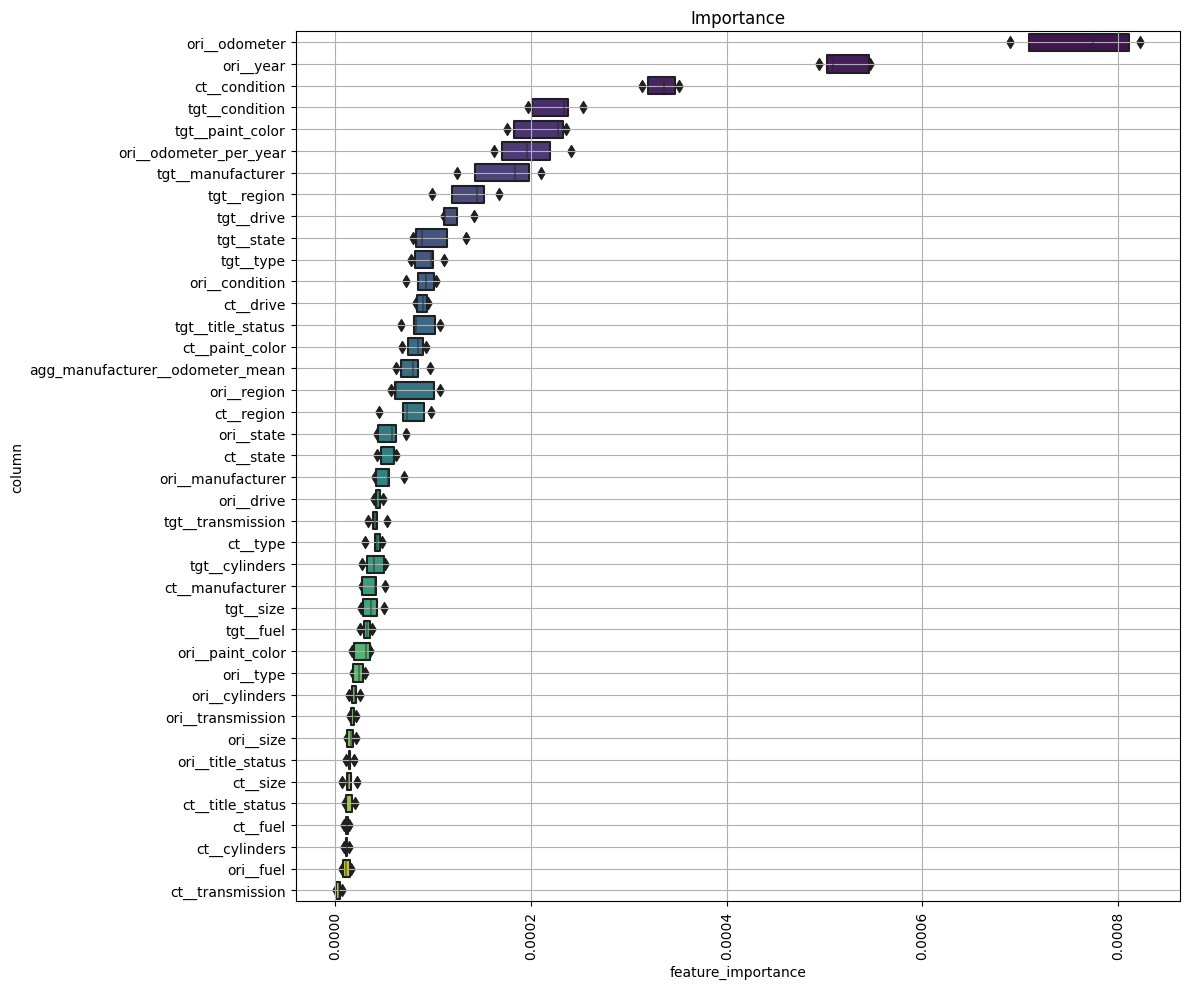

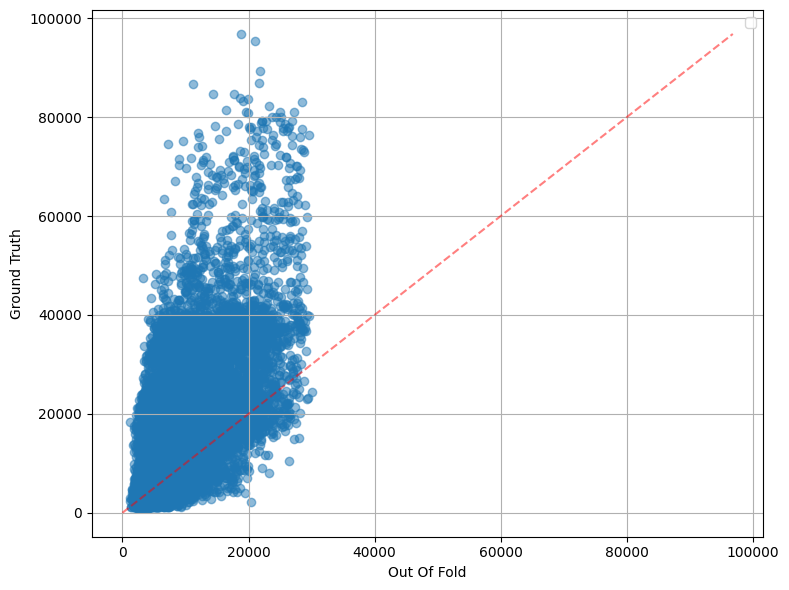

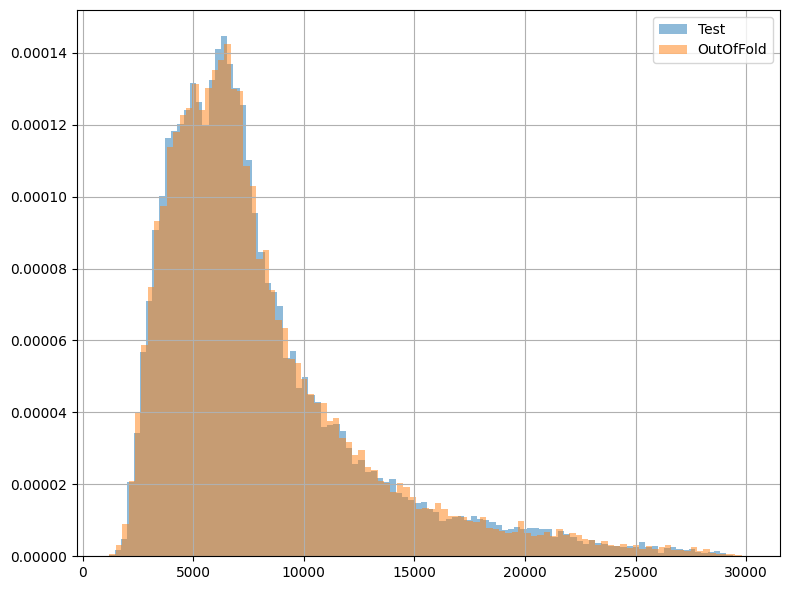

In [ ]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)